# ANALYZING CRIMES IN LOS ANGELES

![alt text](/Users/hangtran/Desktop/Analyzing_LACrimes/Analyzing_LACrimes/la_skyline.jpg)

Los Angeles, California 😎. The City of Angels. Tinseltown. The Entertainment Capital of the World! 

Known for its warm weather, palm trees, sprawling coastline, and Hollywood, along with producing some of the most iconic films and songs. However, as with any highly populated city, it isn't always glamorous and there can be a large volume of crime. That's where you can help!

You have been asked to support the Los Angeles Police Department (LAPD) by analyzing crime data to identify patterns in criminal behavior. They plan to use your insights to allocate resources effectively to tackle various crimes in different areas.

### The Data

They have provided you with a single dataset to use. A summary and preview are provided below.

It is a modified version of the original data, which is publicly available from Los Angeles Open Data.

Crimes.csv
| Column     | Description              |
|------------|--------------------------|
| `'DR_NO'` | Division of Records Number: Official file number made up of a 2-digit year, area ID, and 5 digits. |
| `'Date Rptd'` | Date reported - MM/DD/YYYY. |
| `'DATE OCC'` | Date of occurrence - MM/DD/YYYY. |
| `'TIME OCC'` | In 24-hour military time. |
| `'AREA NAME'` | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, the 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles. |
| `'Crm Cd Desc'` | Indicates the crime committed. |
| `'Vict Age'` | Victim's age in years. |
| `'Vict Sex'` | Victim's sex: `F`: Female, `M`: Male, `X`: Unknown. |
| `'Vict Descent'` | Victim's descent:<ul><li>`A` - Other Asian</li><li>`B` - Black</li><li>`C` - Chinese</li><li>`D` - Cambodian</li><li>`F` - Filipino</li><li>`G` - Guamanian</li><li>`H` - Hispanic/Latin/Mexican</li><li>`I` - American Indian/Alaskan Native</li><li>`J` - Japanese</li><li>`K` - Korean</li><li>`L` - Laotian</li><li>`O` - Other</li><li>`P` - Pacific Islander</li><li>`S` - Samoan</li><li>`U` - Hawaiian</li><li>`V` - Vietnamese</li><li>`W` - White</li><li>`X` - Unknown</li><li>`Z` - Asian Indian</li> |
| `'Weapon Desc'` | Description of the weapon used (if applicable). |
| `'Status Desc'` | Crime status. |
| `'LOCATION'` | Street address of the crime. |


## Using this dataset, they are asking questions about 
1. Which hour has the highest frequency of crimes?
2. Which area has the largest frequency of night crimes? (crimes committed between 10pm and 3:59am)
3. Identify the number of crimes committed against victims of different age groups
4. Build a ML model to predict the area with the highest frequency of night crimes?

In [2]:
# Import libraries and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

crimes = pd.read_csv("/Users/hangtran/Desktop/Analyzing_LACrimes/Analyzing_LACrimes/crimes.csv", dtype = {"TIME OCC":str})

### 1. What hour has the highest frequency of crimes?

Text(0, 0.5, 'Number of Crimes')

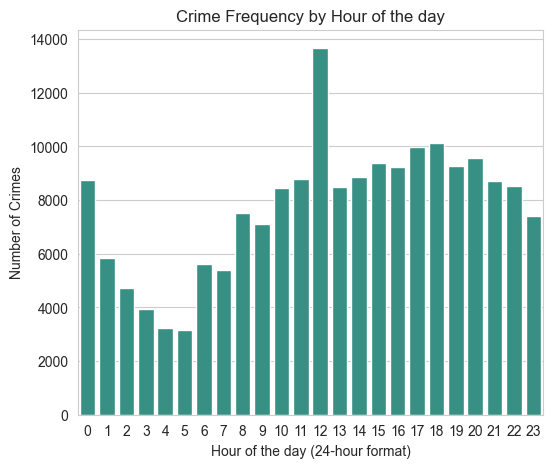

In [7]:
# Extract the hour
crimes['HOUR_OCC'] = crimes['TIME OCC'].str[:2].astype(int)

# Plotting the frequencies
plt.figure(figsize=(6,5))
sns.set_style('whitegrid')
sns.countplot(data = crimes, x = 'HOUR_OCC', color="#2a9d8f", linewidth=1, edgecolor= 'white')
plt.title("Crime Frequency by Hour of the day")
plt.xlabel("Hour of the day (24-hour format)")
plt.ylabel("Number of Crimes")

### 2. Which area has the largest frequency of night crimes? (crimes committed between 10pm and 3:59am)

In [8]:
# Subsetting for night hour
crimes_night = crimes[crimes['HOUR_OCC'].isin([22,23,0,1,2,3])]

# Counting crimes by area
peak_night_crime_location = crimes_night.groupby("AREA NAME").size().sort_values(ascending=False).astype(str).index[0]
print(f"{peak_night_crime_location} has the largest frequency of night crimes in LA")


Central has the largest frequency of night crimes in LA


### 3. Identify the number of crimes committed against victims of different age groups

In [9]:
# Crimes against victims of different age groups
list_of_age = [0, 17, 25, 34, 44, 54, 64, np.inf]
labels = ["0-17", "18-25", "26-34", "35-44", "45-54", "55-64", "65+"]
crimes["Age Bracket"] = pd.cut(crimes["Vict Age"], bins = list_of_age, labels = labels, right = True)
victim_ages = crimes["Age Bracket"].value_counts().sort_values(ascending=False)
print(victim_ages)

Age Bracket
26-34    47470
35-44    42157
45-54    28353
18-25    28291
55-64    20169
65+      14747
0-17      4528
Name: count, dtype: int64


### 4. Build a ML model to predict the area with the high frequency of night crimes?

#### 4.1 EDA

In [10]:
# Check for missing value
print(crimes_night.isna().sum().sort_values())

DR_NO               0
Date Rptd           0
DATE OCC            0
TIME OCC            0
AREA NAME           0
Crm Cd Desc         0
Vict Age            0
Status Desc         0
LOCATION            0
HOUR_OCC            0
Vict Descent        4
Vict Sex            5
Weapon Desc     21975
dtype: int64


In [11]:
# Fill missing values with SimpleImputer for categorical
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
col_imputed = ["Vict Descent", "Vict Sex", "Weapon Desc"]
crimes_night[col_imputed] = imputer.fit_transform(crimes_night[col_imputed])


/var/folders/s5/nf310n696q5ffj080h450nsr0000gn/T/ipykernel_62521/1393586283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_night[col_imputed] = imputer.fit_transform(crimes_night[col_imputed])


In [12]:
# Drop irrevalent columns
col_drop = ["DR_NO", "Date Rptd", "LOCATION", "HOUR_OCC"]
crimes_night = crimes_night.drop(columns=col_drop, errors='ignore')

In [13]:
# One hot encoding for categorical columns
col_encode = ["Crm Cd Desc", "Vict Sex", "Vict Descent", "Weapon Desc", "Status Desc"]
encoder = OneHotEncoder(sparse_output=False, handle_unknown= 'ignore')
encoded = encoder.fit_transform(crimes_night[col_encode])

# Convert to df
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(col_encode),
    index=crimes_night.index
)

# Drop the original col_encode in crimes_night and add encoded_df
crimes_night_encoded = pd.concat(
    [crimes_night.drop(columns=col_encode),
    encoded_df],
    axis = 1
)

In [14]:
# Scale numeric columns
num_col = ["Vict Age"]
scaler = StandardScaler()
crimes_night_encoded[num_col] = scaler.fit_transform(crimes_night_encoded[num_col])

In [15]:
# Encode the target
label_encoder = LabelEncoder()
crimes_night_encoded['AREA_NAME_ENCODED'] = label_encoder.fit_transform(crimes_night_encoded["AREA NAME"])

In [16]:
# Clean out the columns name
crimes_night_encoded.columns = crimes_night_encoded.columns.str.strip()

In [17]:
# Select target and features
X = crimes_night_encoded.drop(['DATE OCC', 'TIME OCC', 'AREA NAME', 'AREA_NAME_ENCODED'], errors='ignore')
y = crimes_night_encoded['AREA_NAME_ENCODED']

In [18]:
# Train split test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Baseline models
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
classification_report(y_test, y_pred)


ValueError: could not convert string to float: '2022-10-01'